# DataCamp Data Analyst Certification Case Study

### The task

Nearly New Nautical is a website that allows users to advertise their used boats for sale. The marketing team is preparing a weekly newsletter for boat owners. The newsletter is designed to help sellers to get more views of their boat, as well as stay on top of market trends. The Head of Marketing has laid out an ambitious goal of increasing the number of readers by 75% this year.

They would like you to take a look at the recent data and help them learn more about the characteristics of the most viewed boat listings in the last 7 days - is it the most expensive boats that get the most views? Are there common features among the most viewed boats?

# Technical report

## Initial analysis

Let's import required modules first.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Importing data and looking at the first 5 rows.

In [ ]:
data = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/boat_data.csv')
data.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


According to the client, the columns data type and meaning is the following:
- `Price (Character)`: boat price listed in different currencies (e.g. EUR, Â£, CHF etc.) on the website
- `Boat Type (Character)`: type of the boat
- `Manufacturer (Character)`: manufacturer of the boat
- `Type (Character)`: condition of the boat and engine type(e.g. Diesel, Unleaded, etc.)
- `Year Built (Numeric)`: year of the boat built
- `Length (Numeric)`: length in meter of the boat
- `Width (Numeric)`: width in meter of the boat
- `Material (Character)`: material of the boat (e.g. GRP, PVC, etc.)
- `Location (Character)`: location of the boat is listed
- `Number of views last 7 days (Numeric)`: number of the views of the list last 7 days

Let's look at the correlation of features:

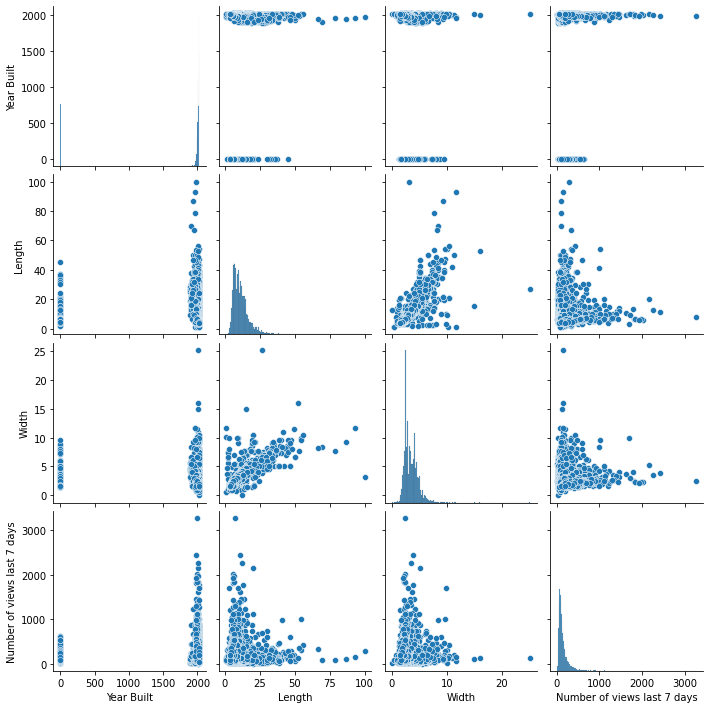

In [20]:
sns.pairplot(data)

The pairplot was plotted only for numeric features.

It is seen that there is no obvious correlation between the column `Number of views last 7 days` and other numeric columns. The `Price` column is not included in the plot, since it is not numeric and consists of currency and price. Preprocessing should be done on that column in order to evaluate it.

## Answering the questions

### Do the most expensive boats that get the most views?

At first we should split the `Price` column, so that is includes `Currency` and `Prices` individual columns. The last one we will convert to the 'float' type.

In [21]:
data['Currency'] = [x.split()[0] for x in data['Price']]
data['Prices'] = [x.split()[1] for x in data['Price']]
data['Prices'] = data['Prices'].astype('float')

Let's see what are the unique values for the currency:

In [22]:
data['Currency'].unique()

array(['CHF', 'EUR', 'DKK', 'Â£'], dtype=object)

So it is Swiss Frank, Euro, Danish Krone and British Pound. 
If we want to include prices in our features for model training, we should make another columns, which is `Price in EUR`, so that all the prices are consistent.

At the first step we should create a dictionary with currency rate and then create another column by using `map` function.

In [23]:
converter = {'CHF':0.97, 'EUR':1, 'DKK':0.13, 'Â£':1.19}
data['Price in EUR'] = data['Currency'].map(converter) * data['Prices']

Let's look at old and new column now.

In [26]:
data[['Price', 'Price in EUR']].head()

,Price,Price in EUR
0,CHF 3337,3236.89
1,EUR 3490,3490.00
2,CHF 3770,3656.90
3,DKK 25900,3367.00
4,EUR 3399,3399.00


Looks good. Now we will plot the scatterplot in order to see the dependence between number of views and the price.

<AxesSubplot:xlabel='Price in EUR', ylabel='Number of views last 7 days'>

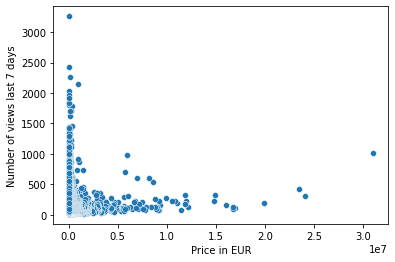

In [35]:
sns.scatterplot(x='Price in EUR', y='Number of views last 7 days', data=data)

It looks that the most expensive boats does not get the most views, as there is a lot of views for cheapest boats. But it seems that the most expensive boats actually get a bit more views. Maybe people were just curious about it.

Let's investigate the price dependence further by limiting the boat price and check for cheaper boats.

<AxesSubplot:xlabel='Price in EUR', ylabel='Number of views last 7 days'>

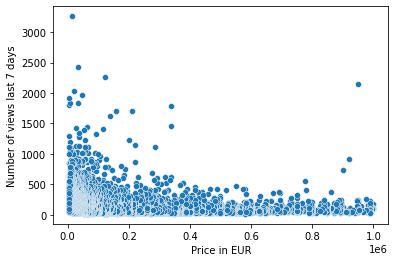

In [48]:
sns.scatterplot(x='Price in EUR', y='Number of views last 7 days', data=data.query('`Price in EUR` < 1e6'))

It looks that there may be slight dependence between price and number of views, as it looks that cheaper boats do actually get a bit more views.

**The answer:**

The most expensive boats do not get more views, as it looks that it is actually the opposite.

### Are there common features among the most viewed boats?

Now we need to analyse the common feature of the most viewed boats. At first let's describe the values of the column and plot the distribution.

In [145]:
data['Number of views last 7 days'].describe()

count    9888.000000
mean      149.160801
std       151.819752
min        13.000000
25%        70.000000
50%       108.000000
75%       172.000000
max      3263.000000
Name: Number of views last 7 days, dtype: float64

It is seen that the mean value of the views is around 150. The median for that is 108.

Now we need to decide, what do we consider as most viewed and least viewed boats. Let's check the histogram of the plot.

<AxesSubplot:xlabel='Number of views last 7 days', ylabel='Count'>

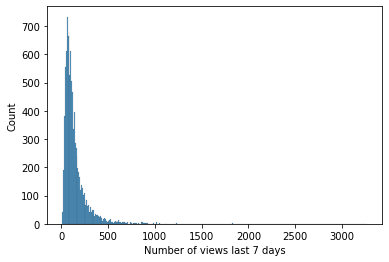

In [146]:
sns.histplot(x='Number of views last 7 days', data=data)

The views that are too high can be considered as outliers, as there can be only couple of such boats in the whole dataset.

Now we can turn to analysis of every categorical feature. In order to get rid of the outliers we can only use the data for the most common values of each feature.

#### Boat type

We should group our data by boat type and then calculate the mean of the views that it gets.

We can limit only to first 10 most common boat types and then limit our data to only most popular boat types and plot the top 5 types based on mean number of views it gets.

At first we will write a function that does that.

In [338]:
def plot_popular_items(column):
    popular = data[column].value_counts()[:10].index
    popular_data = (data[data[column].isin(popular)].
                           groupby(column)['Number of views last 7 days'].
                           mean().
                           sort_values(ascending=False)[:5])
    popular_data.plot(kind='bar', rot=45)
    plt.show()
    print(f'The most popular {column}:')
    print(*popular_data.index, sep='\n')  

Now let's use the function on the Boat Type.

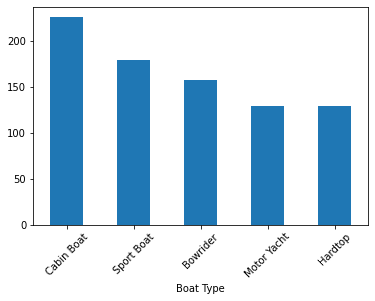

The most popular Boat Type:
Cabin Boat
Sport Boat
Bowrider
Motor Yacht
Hardtop


In [339]:
plot_popular_items('Boat Type')

#### Manufacturer

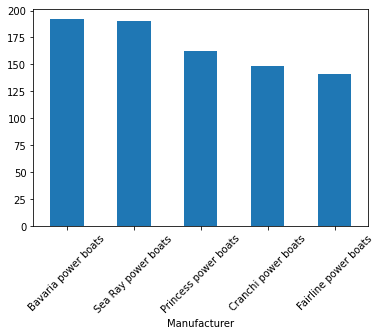

The most popular Manufacturer:
Bavaria power boats
Sea Ray power boats
Princess power boats
Cranchi power boats
Fairline power boats


In [285]:
plot_popular_items('Manufacturer')

#### Type

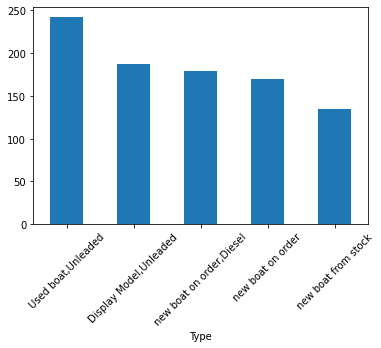

The most popular Type:
Used boat,Unleaded
Display Model,Unleaded
new boat on order,Diesel
new boat on order
new boat from stock


In [ ]:
plot_popular_items('Type')

#### Material

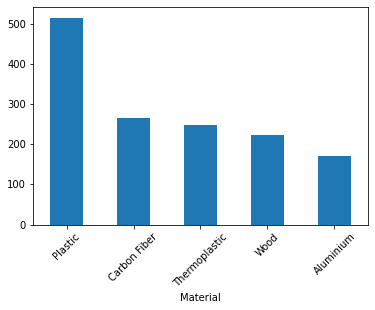

The most popular Material:
Plastic
Carbon Fiber
Thermoplastic
Wood
Aluminium


In [287]:
plot_popular_items('Material')

#### Location

In order to use correctly use location we should just extract the country out of it.

In [291]:
data['Country'] = list(map(lambda row: row.split()[0], data['Location']))

Now we can plot the most popular countries.

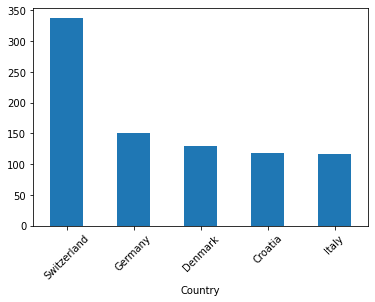

The most popular Country:
Switzerland
Germany
Denmark
Croatia
Italy


In [292]:
plot_popular_items('Country')

#### Finding the most popular boats

From the results that we got we can conclude that the most popular boat should be:
- Be `Used/Unleaded`.
- Made from `Plastic`.
- Be from `Switzerland`.

We should not specify `Manufacturer` and `Boat Type` as they do not give a lot of change in views.

Now let's filter for such boats and look at the first 5 rows. 

In [332]:
most_popular_data = data[(data['Type'] == 'Used boat,Unleaded') &
                         (data['Material'] == 'Plastic') &
                         (data['Country'] == 'Switzerland')]
most_popular_data.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Prices,Price in EUR,Country
36,CHF 3800,Fishing Boat,Hensa power boats,"Used boat,Unleaded",1974,5.40,1.67,Plastic,Switzerland Â» Sihlsee,849,CHF,3800.0,3686.0,Switzerland
57,CHF 7200,Sport Boat,Fiberline power boats,"Used boat,Unleaded",1987,3.95,1.55,Plastic,Switzerland Â» Lake of Zurich Â» ZÃ¼richsee od...,1201,CHF,7200.0,6984.0,Switzerland
278,CHF 18900,Sport Boat,Campion power boats,"Used boat,Unleaded",2001,5.71,2.34,Plastic,Switzerland Â» Lago Maggiore Â» Minusio bei Lo...,335,CHF,18900.0,18333.0,Switzerland
279,CHF 18900,Sport Boat,Sunbird power boats,"Used boat,Unleaded",1990,6.50,2.45,Plastic,Switzerland Â» Lake Constance Â» Ermatingen,686,CHF,18900.0,18333.0,Switzerland
308,CHF 19900,Sport Boat,Sea Ray power boats,"Used boat,Unleaded",1993,6.14,2.34,Plastic,Switzerland Â» Murtensee Â» Avenches,2026,CHF,19900.0,19303.0,Switzerland


We can see that indeed those boats get a lot of views.

Let's find the mean of the views of such boats.

In [333]:
most_popular_data['Number of views last 7 days'].mean()

802.5909090909091

Indeed, the mean views of such boats is around 800 and is way higher than the mean value of views of all the boats, which is 150.

## Conclusion

In this project our task was to identify whether:
- The most expensive boats get the most views.
- There are common features among the most viewed boats.

In the result we discovered that:
- The most expensive boats do not get the most views. We can say that it is actually the opposite, as there is slight trend of the less expensive boats getting more views.
- By using only 10 most popular types of each feature and plotting corresponding barplots we identified that the most popular boats would be `Used/Unleaded`, made of `Plastic` and be from `Switzerland`. The mean value of views of such boats is around 800, which is higher that the mean value of 150.